<a href="https://colab.research.google.com/github/mridul-d/python-notebooks/blob/main/img_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Important notes
- epochs were 50, but ran only 5 times to test the code
- removed 2 conv layers. the number of layers needs to be investigated
- training data was kept in google drive for test purpose. the path will have to be changed eventually
- image size is 150 x 150. this needs to validated for all images. If sizes are different, then all images need to get resized in preprocessing

#### Set variables and import data

In [1]:
import numpy as np
import os

from tensorflow.keras import models, layers

import tensorflow as tf
import matplotlib.pyplot as plt

In [62]:
BATCH_SIZE = 32
IMAGE_SIZE = 150
CHANNELS=3
EPOCHS=5

In [48]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Colab_data/img_classification/seg_train",
    shuffle=True,
    seed=42,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


"""
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Colab_data/img_classification/seg_test",
    shuffle=True,
    seed=42,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)
"""

Found 2541 files belonging to 6 classes.


'\ntest_ds = tf.keras.preprocessing.image_dataset_from_directory(\n    "/content/drive/MyDrive/Colab_data/img_classification/seg_test",\n    shuffle=True,\n    seed=42,\n    image_size=(IMAGE_SIZE, IMAGE_SIZE),\n    batch_size=BATCH_SIZE\n)\n'

In [49]:
class_names = train_ds.class_names

### Split training data into train and val (we already have test)

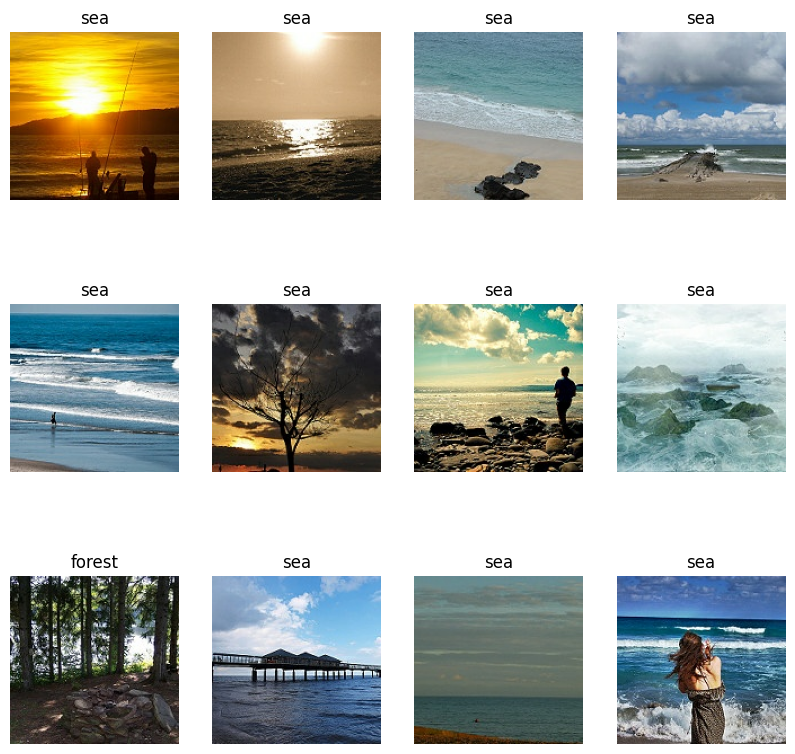

In [51]:
# Visualise some of the images in the dataset
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [52]:
# Split dataset into test and val datasets
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.2, shuffle=True, shuffle_size=10000):
    assert (train_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size)

    return train_ds, val_ds


train_ds, val_ds = get_dataset_partitions_tf(train_ds)

In [53]:
print(len(train_ds))
print(len(val_ds))

64
16


In [54]:
# Performance optimisation for the datasets
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

#### Preprocessing

In [55]:
# Creating a layer for resizing and normalisation
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# Creating a later for data augmentation. This is useful when there is less data
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

#### Model Architecture

In [66]:
# Apply data augmentation to the training dataset
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [67]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(30, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(60,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(60,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(60, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(60, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [68]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 conv2d_16 (Conv2D)          (32, 148, 148, 30)        840       
                                                                 
 max_pooling2d_16 (MaxPoolin  (32, 74, 74, 30)         0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (32, 72, 72, 60)          16260     
                                                                 
 max_pooling2d_17 (MaxPoolin  (32, 36, 36, 60)         0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (32, 34, 34, 60)         

#### Compile the model

In [60]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [63]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_ds,
    verbose=1
)

Epoch 1/5
64/64 [==============================] - 149s 2s/step - loss: 0.1137 - accuracy: 0.9590 - val_loss: 0.0583 - val_accuracy: 0.9863
Epoch 2/5
64/64 [==============================] - 102s 2s/step - loss: 0.0625 - accuracy: 0.9824 - val_loss: 0.0704 - val_accuracy: 0.9902
Epoch 3/5
64/64 [==============================] - 101s 2s/step - loss: 0.0478 - accuracy: 0.9844 - val_loss: 0.0522 - val_accuracy: 0.9785
Epoch 4/5
64/64 [==============================] - 104s 2s/step - loss: 0.0580 - accuracy: 0.9849 - val_loss: 0.0331 - val_accuracy: 0.9883
Epoch 5/5
64/64 [==============================] - 105s 2s/step - loss: 0.0401 - accuracy: 0.9858 - val_loss: 0.1050 - val_accuracy: 0.9727


#### Plot model accuracy and loss

In [64]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

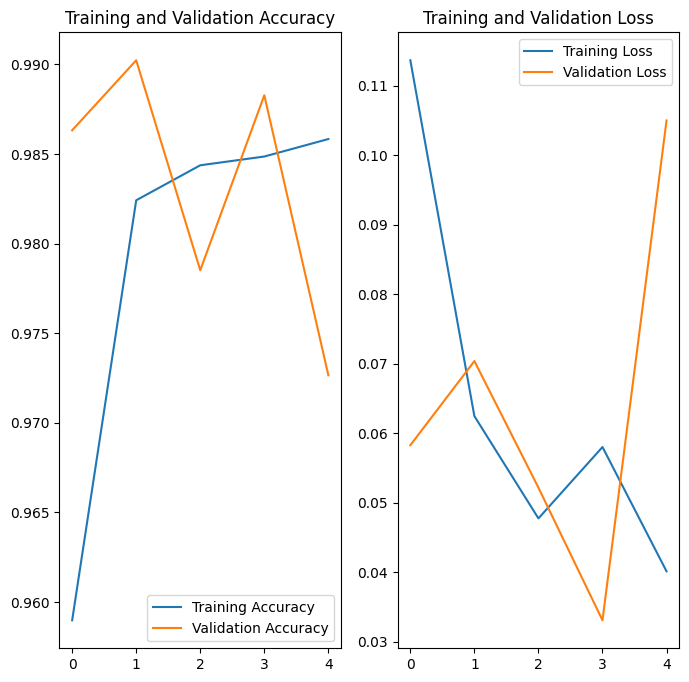

In [65]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Prediction on unseen data

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
# Function for inference
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
# Run inference on a few sample images
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

#### Save the model (optional)

In [ ]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

In [ ]:
model.save("../potatoes.h5")